In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
%matplotlib inline  

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
import os
img_dir = 'small_correct-images/'
import matplotlib.image as mpimg

In [4]:
thesis_embeddings = pd.read_csv('thesis_face_embeddings/guess_who_embeddings_pandas.csv')

emb = thesis_embeddings.encodings

emb = (emb
 .str.replace('\n','')
 .str.replace('\r','')
 .str.replace('[','')
 .str.replace(']','')
 .str.split())

emb_lists = emb.tolist()

thesis_emb = np.asarray(emb_lists)

thesis_emb = thesis_emb.astype(np.float)

In [5]:
X_test = thesis_emb

In [6]:
df = pd.read_csv('csv/thesis_faces_ground_truth.csv')

gt = pd.read_csv('csv/thesis_ethn_ground_truth.csv')

In [7]:
df.columns

Index(['Unnamed: 0', 'faceID', 'face_perceived_physical-description',
       'face_perceived_ethnicity', 'face_perceived_ethnicity-details',
       'face_perceived_eye', 'face_perceived_hair',
       'face_perceived_photo-gender', 'uniqueID', 'face_gender_mode',
       'face_gender_consensus', 'glasses_mentioned', 'glasses',
       'eye_consensus_prop', 'eye_perceived', 'nr_eye_col',
       'hair_consensus_prop', 'hair_perceived', 'nr_hair_col'],
      dtype='object')

In [8]:
betterface = pd.read_csv('csv/better_face_level_ethnicity.csv')

In [9]:
betterface = betterface.sort_values('faceID').reset_index().drop(columns='index')

In [10]:
betterface.ethnicity.value_counts()

white        126
asian         46
ambiguous     12
latino         7
african        2
Name: ethnicity, dtype: int64

In [ ]:
betterface.e

In [11]:
betterface.value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [12]:
ethn_df = df[['faceID']].sort_values('faceID').reset_index().drop(columns='index')


In [9]:
gt.ethnicity.value_counts()

white    134
asian     41
other     16
black      2
Name: ethnicity, dtype: int64

In [30]:
gt.shape

(193, 2)

In [13]:
ethn_keras_model = pickle.load(open('lfwa+/ethnicity_keras_model.sav', 'rb'))

C:\Users\Paradigit\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
y_prob = ethn_keras_model.predict(X_test)
y_pred = (y_prob > 0.5)

In [15]:
y_prob[0]

array([3.0678278e-04, 5.7302648e-04, 9.9912018e-01], dtype=float32)

In [16]:
y = pd.DataFrame(y_prob)

In [17]:
y = y.rename(columns={ y.columns[0]: "asian" }).rename(columns={ y.columns[1]: "black" }).rename(columns={ y.columns[2]: "white" })

In [18]:
y.head()

,asian,black,white
0,0.000307,0.000573,0.999120
1,0.000830,0.000312,0.998859
2,0.102275,0.001490,0.896235
3,0.030901,0.000621,0.968477
4,0.009134,0.000415,0.990452


In [19]:
resultdf = pd.concat([ethn_df, y], axis=1)


In [20]:
#resultdf['ethnicity'] = gt.ethnicity
resultdf['ethnicity'] = betterface.ethnicity

In [58]:
resultdf.head(2)

,faceID,asian,black,white,ethnicity
0,IMG_0003,0.000307,0.000573,0.999120,white
1,IMG_0018,0.000830,0.000312,0.998859,white


In [21]:
def prediction(row):
    if row.asian < 0.5 and row.black < 0.5 and row.white < 0.5:
        return 'other'
    
    elif row.asian > row.black and row.asian > row.white:
        return 'asian'
    
    elif row.black > row.asian and row.black > row.white:
        return 'african'
    
    else:
        return 'white'


In [22]:
resultdf['prediction'] = resultdf.apply(prediction, axis=1)

In [61]:
resultdf.prediction.value_counts()

white      145
asian       42
african      3
other        3
Name: prediction, dtype: int64

In [62]:
resultdf.ethnicity.value_counts()

white        126
asian         46
ambiguous     12
latino         7
african        2
Name: ethnicity, dtype: int64

In [60]:
resultdf.head(2)

,faceID,asian,black,white,ethnicity,prediction
0,IMG_0003,0.000307,0.000573,0.999120,white,white
1,IMG_0018,0.000830,0.000312,0.998859,white,white


In [23]:
#change latino and ambigious values to other since my models cant predict those
resultdf.loc[resultdf.ethnicity == 'latino','ethnicity'] = 'other'
resultdf.loc[resultdf.ethnicity == 'ambiguous','ethnicity'] = 'other'

#resultdf.loc[resultdf.ethnicity == 'african','ethnicity'] = 'black'

In [24]:
gw_asian = resultdf[resultdf.ethnicity == 'asian']

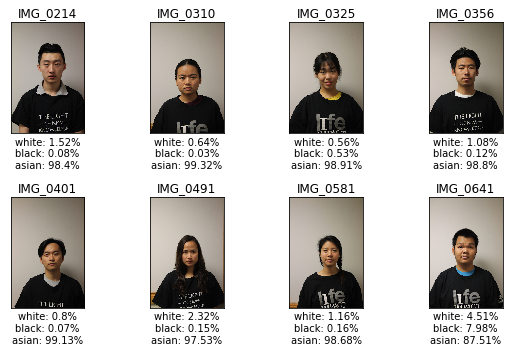

In [28]:
gw_asian = resultdf[resultdf.ethnicity == 'asian']

asian_asian = gw_asian[gw_asian.prediction == 'asian']

plt.figure(figsize=(8,5))
for i, face in enumerate(asian_asian.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(asian_asian.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(asian_asian.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(asian_asian.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

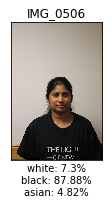

In [33]:
gw_asian = resultdf[resultdf.ethnicity == 'asian']

asian_b = gw_asian[gw_asian.prediction == 'african']

plt.figure(figsize=(8,5))
for i, face in enumerate(asian_b.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(asian_b.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(asian_b.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(asian_b.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

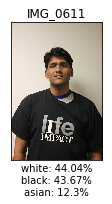

In [40]:
gw_asian = resultdf[resultdf.ethnicity == 'asian']

asian_o = gw_asian[gw_asian.prediction == 'other']

plt.figure(figsize=(8,5))
for i, face in enumerate(asian_o.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(asian_o.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(asian_o.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(asian_o.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

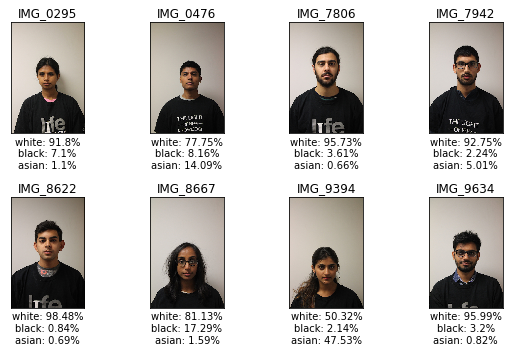

In [34]:
gw_asian = resultdf[resultdf.ethnicity == 'asian']

asian_w = gw_asian[gw_asian.prediction == 'white']

plt.figure(figsize=(8,5))
for i, face in enumerate(asian_w.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(asian_w.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(asian_w.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(asian_w.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

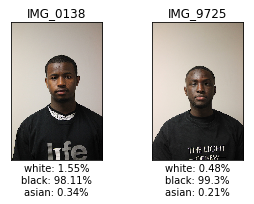

In [35]:
gw_black = resultdf[resultdf.ethnicity == 'african']

black_b = gw_black[gw_black.prediction == 'african']

plt.figure(figsize=(8,5))
for i, face in enumerate(black_b.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(black_b.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(black_b.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(black_b.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

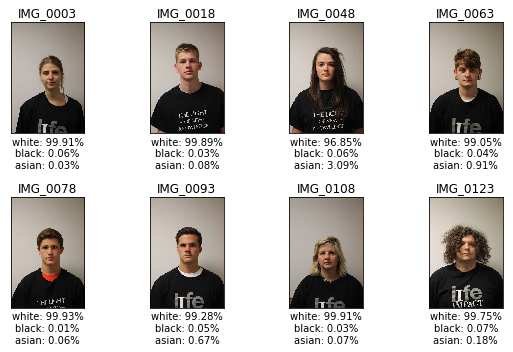

In [38]:
gw_white = resultdf[resultdf.ethnicity == 'white']

white_w = gw_white[gw_white.prediction == 'white']

plt.figure(figsize=(8,5))
for i, face in enumerate(white_w.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(white_w.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(white_w.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(white_w.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

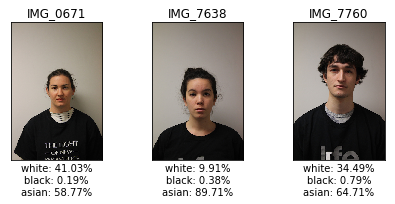

In [39]:
gw_white = resultdf[resultdf.ethnicity == 'white']

white_a = gw_white[gw_white.prediction == 'asian']

plt.figure(figsize=(8,5))
for i, face in enumerate(white_a.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(white_a.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(white_a.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(white_a.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

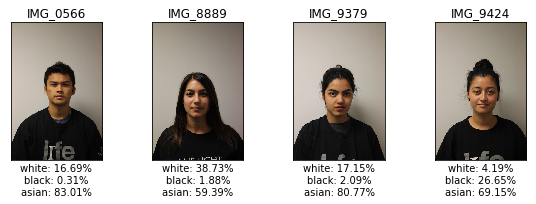

In [41]:
gw_oth = resultdf[resultdf.ethnicity == 'other']

oth_a = gw_oth[gw_oth.prediction == 'asian']

plt.figure(figsize=(8,5))
for i, face in enumerate(oth_a.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(oth_a.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(oth_a.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(oth_a.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

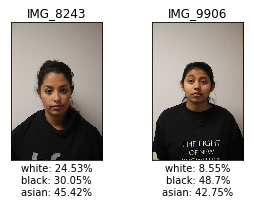

In [42]:
gw_oth = resultdf[resultdf.ethnicity == 'other']

oth_o = gw_oth[gw_oth.prediction == 'other']

plt.figure(figsize=(8,5))
for i, face in enumerate(oth_o.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(oth_o.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(oth_o.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(oth_o.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

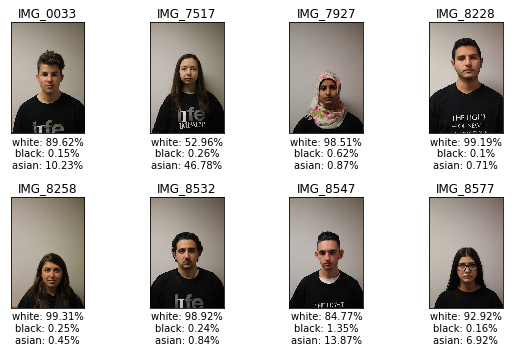

In [43]:
gw_oth = resultdf[resultdf.ethnicity == 'other']

oth_w = gw_oth[gw_oth.prediction == 'white']

plt.figure(figsize=(8,5))
for i, face in enumerate(oth_w.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(oth_w.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(oth_w.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(oth_w.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

In [26]:
gw_asian[gw_asian.prediction == 'asian']

,faceID,asian,black,white,ethnicity,prediction
14,IMG_0214,0.983985,0.000840,0.015174,asian,asian
18,IMG_0310,0.993243,0.000332,0.006425,asian,asian
19,IMG_0325,0.989106,0.005315,0.005579,asian,asian
21,IMG_0356,0.987985,0.001177,0.010838,asian,asian
24,IMG_0401,0.991283,0.000706,0.008011,asian,asian
30,IMG_0491,0.975317,0.001476,0.023207,asian,asian
36,IMG_0581,0.986797,0.001640,0.011563,asian,asian
40,IMG_0641,0.875119,0.079752,0.045129,asian,asian
44,IMG_0701,0.988118,0.001483,0.010399,asian,asian
45,IMG_0716,0.958871,0.000183,0.040946,asian,asian


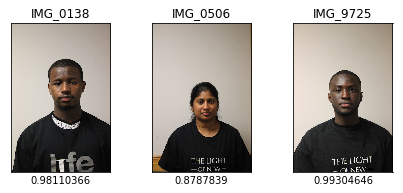

In [25]:

black = resultdf[resultdf.prediction == 'african']

plt.figure(figsize=(8,5))
for i, face in enumerate(black.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel(black.black.values[i])

plt.tight_layout()
plt.show()

In [99]:
asian_pred_other = resultdf[(resultdf.ethnicity == 'asian') & (resultdf.prediction != 'asian')]
asian_pred_other

,faceID,asian,black,white,ethnicity,prediction
17,IMG_0295,0.011012,0.070977,0.918011,asian,white
29,IMG_0476,0.140943,0.081574,0.777483,asian,white
31,IMG_0506,0.048243,0.878784,0.072973,asian,african
38,IMG_0611,0.122951,0.436666,0.440384,asian,other
71,IMG_7806,0.006606,0.036108,0.957286,asian,white
80,IMG_7942,0.050088,0.022364,0.927548,asian,white
111,IMG_8622,0.006860,0.008373,0.984767,asian,white
114,IMG_8667,0.015857,0.172885,0.811258,asian,white
153,IMG_9394,0.475328,0.021436,0.503236,asian,white
169,IMG_9634,0.008156,0.031957,0.959886,asian,white


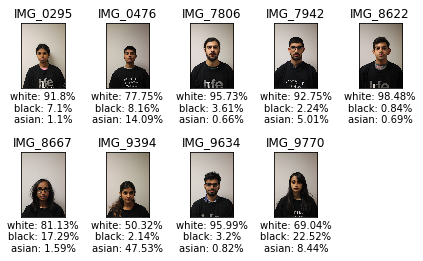

In [72]:
asian_white = asian_pred_other[asian_pred_other.prediction == 'white']
plt.figure(figsize=(6,5))
for i, face in enumerate(asian_white.faceID.values):
    
    plt.subplot(3,5,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('white' + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(asian_white.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(asian_white.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

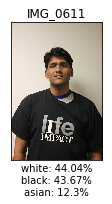

In [71]:
asian_other = asian_pred_other[asian_pred_other.prediction == 'other']

plt.figure(figsize=(8,5))
for i, face in enumerate(asian_other.faceID.values):
    
    plt.subplot(2,3,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    (plt.xlabel('white' + ': ' + str(round(asian_other.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(asian_other.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(asian_other.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

In [100]:
white_pred_other = resultdf[(resultdf.ethnicity == 'white') & (resultdf.prediction != 'white')]
white_pred_other

,faceID,asian,black,white,ethnicity,prediction
42,IMG_0671,0.587729,0.001929,0.410342,white,asian
60,IMG_7638,0.897100,0.003835,0.099065,white,asian
68,IMG_7760,0.647148,0.007926,0.344926,white,asian


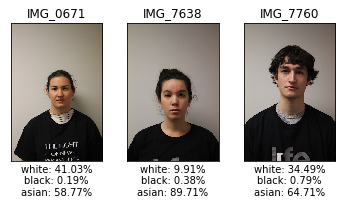

In [102]:


plt.figure(figsize=(5,5))
for i, face in enumerate(white_pred_other.faceID.values):
    
    plt.subplot(2,3,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    (plt.xlabel('white' + ': ' + str(round(white_pred_other.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(white_pred_other.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(white_pred_other.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

In [97]:
other_pred = resultdf[(resultdf.ethnicity == 'other')]
other_pred

,faceID,asian,black,white,ethnicity,prediction
2,IMG_0033,0.102275,0.001490,0.896235,other,white
35,IMG_0566,0.830062,0.003087,0.166850,other,asian
52,IMG_7517,0.467823,0.002564,0.529613,other,white
79,IMG_7927,0.008713,0.006200,0.985087,other,white
98,IMG_8228,0.007131,0.001002,0.991866,other,white
99,IMG_8243,0.454247,0.300501,0.245253,other,other
100,IMG_8258,0.004452,0.002494,0.993054,other,white
105,IMG_8532,0.008394,0.002382,0.989223,other,white
106,IMG_8547,0.138750,0.013527,0.847724,other,white
108,IMG_8577,0.069246,0.001575,0.929179,other,white


FileNotFoundError: [Errno 2] No such file or directory: 'small_correct-images/other.JPG'

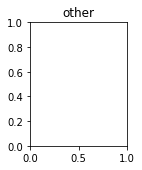

In [96]:
otherother = other_pred[other_pred.prediction == 'other']


plt.figure(figsize=(8,5))

for i, face in enumerate(otherother.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    (plt.xlabel('white' + ': ' + str(round(otherother.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(otherother.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(otherother.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()

plt.show()

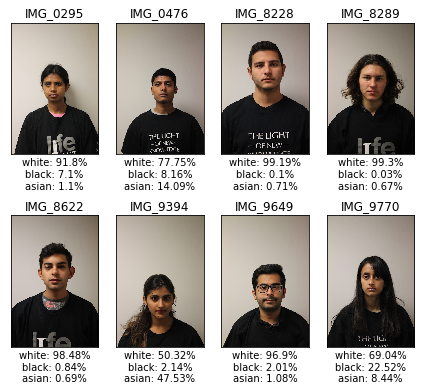

In [62]:
otherwhite = other_pred[other_pred.prediction == 'white']


plt.figure(figsize=(6,5.5))

for i, face in enumerate(otherwhite.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    (plt.xlabel('white' + ': ' + str(round(otherwhite.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(otherwhite.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(otherwhite.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()

plt.show()

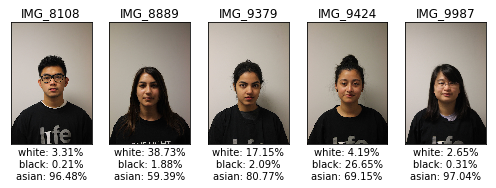

In [65]:
otherasian = other_pred[other_pred.prediction == 'asian']


plt.figure(figsize=(7,5.5))

for i, face in enumerate(otherasian.faceID.values):
    
    plt.subplot(1,5,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    (plt.xlabel('white' + ': ' + str(round(otherasian.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(otherasian.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(otherasian.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()

plt.show()

In [98]:
otherblack = other_pred[other_pred.prediction == 'african']


plt.figure(figsize=(7,5.5))

for i, face in enumerate(otherblack.faceID.values):
    
    plt.subplot(1,1,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    (plt.xlabel('white' + ': ' + str(round(otherblack.white.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(otherblack.black.values[i] * 100, 2)) + "%\n"
               'asian' + ': ' + str(round(otherblack.asian.values[i] * 100, 2)) + "%"))

plt.tight_layout()

plt.show()

<Figure size 504x396 with 0 Axes>

In [60]:
otherwhite.shape

(8, 6)

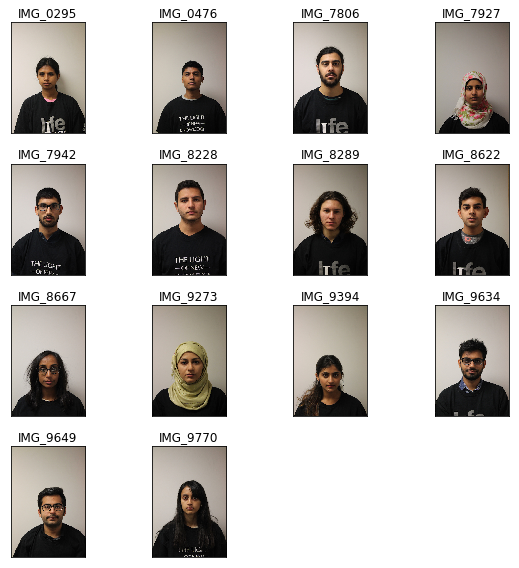

In [72]:
notwhite_white = resultdf[(resultdf.ethnicity != 'white') & (resultdf.prediction == 'white')]

plt.figure(figsize=(8,8))

for i, face in enumerate(notwhite_white.faceID.values):
    
    plt.subplot(4,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel('prediction: ' + white_wrong.prediction.values[i] + ' ' + str(round(white_wrong.asian.values[i], 2)) )

plt.tight_layout()

plt.show()

(14, 6)

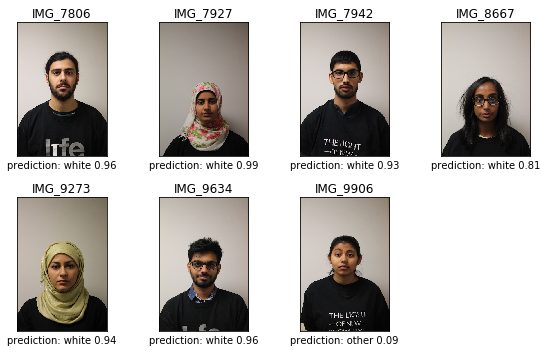

In [78]:
#true asian and prediction not asian
asian_wrong = resultdf[(resultdf.ethnicity == 'asian') & (resultdf.prediction != 'asian')]

plt.figure(figsize=(8,5))

for i, face in enumerate(asian_wrong.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel('prediction: ' + asian_wrong.prediction.values[i] + ' ' + str(round(asian_wrong.white.values[i], 2)) )

plt.tight_layout()

plt.show()

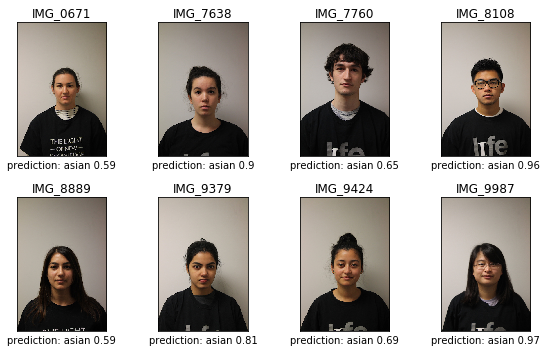

In [82]:
#no asian and prediction  asian
not_asian_wrong = resultdf[(resultdf.ethnicity != 'asian') & (resultdf.prediction == 'asian')]

plt.figure(figsize=(8,5))

for i, face in enumerate(not_asian_wrong.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel('prediction: ' + not_asian_wrong.prediction.values[i] + ' ' + str(round(not_asian_wrong.asian.values[i], 2)) )

plt.tight_layout()

plt.show()

In [59]:
asian_wrong

,faceID,asian,black,white,ethnicity,prediction
71,IMG_7806,0.006606,0.036108,0.957286,asian,white
79,IMG_7927,0.008713,0.006200,0.985087,asian,white
80,IMG_7942,0.050088,0.022364,0.927548,asian,white
114,IMG_8667,0.015857,0.172885,0.811258,asian,white
145,IMG_9273,0.053767,0.006058,0.940175,asian,white
169,IMG_9634,0.008156,0.031957,0.959886,asian,white
187,IMG_9906,0.427512,0.487031,0.085457,asian,other


In [37]:
def confusion(row):
    if row.ethnicity == 'white':
        if row.prediction == 'white':
            return 'true_white'
        
        if row.prediction == 1:
            return 'false_glasses'
    
    if row.glasses == 1:
        if row.pred_glasses == 0:
            return 'false_no_glasses'
        if row.pred_glasses == 1:
            return 'true_glasses'


In [93]:
y_test = resultdf.ethnicity
y_predict = resultdf.prediction

In [94]:
print("{:.3}".format(accuracy_score(y_test, y_predict)))

print(classification_report(y_test,y_predict))

print(confusion_matrix(y_test,y_predict))

0.839
             precision    recall  f1-score   support

    african       0.67      1.00      0.80         2
      asian       0.83      0.76      0.80        46
      other       0.67      0.11      0.18        19
      white       0.85      0.98      0.91       126

avg / total       0.82      0.84      0.81       193

[[  2   0   0   0]
 [  1  35   1   9]
 [  0   4   2  13]
 [  0   3   0 123]]
